## Association subtypes language task

In [1]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_LANGUAGE_18-Jun-2017/';
path_association =  os.path.join(path_root,'associations/');
path_networks =  os.path.join(path_root,'networks/');

In [6]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno = sorted(list_pheno)
list_pheno

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9']

In [7]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['story']

In [8]:
list_subtype = ['sub1','sub2','sub3','sub4','sub5']

In [9]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_root,'{}_r2.csv'.format(trial_name)))

In [10]:
pheno_r2_final

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
sub1,0.031365,0.038060,0.029533,0.046171,0.036431,0.030244,0.030823,0.029535,0.051124
sub2,0.040732,0.029860,0.025771,0.085480,0.039803,0.025138,0.026600,0.027787,0.044652
sub3,0.031662,0.038123,0.031036,0.047346,0.037537,0.031003,0.031731,0.031316,0.053237
sub4,0.024919,0.033241,0.029702,0.029539,0.030472,0.029882,0.028140,0.028319,0.046491
sub5,0.031779,0.040206,0.032998,0.045240,0.038847,0.033831,0.033092,0.032289,0.054352


### On first run in new machine do
Step 1 — Installing System Dependencies for devtools

`sudo apt-get install build-essential libcurl4-gnutls-dev libxml2-dev libssl-dev libcairo2-dev r-cran-stringr`

Step 2 — Installing the Devtools Package

```sudo -i R
install.packages('devtools')
devtools::install_github("hadley/svglite")
devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)```

In [22]:
%%R
library(ggradar)
library(svglite)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

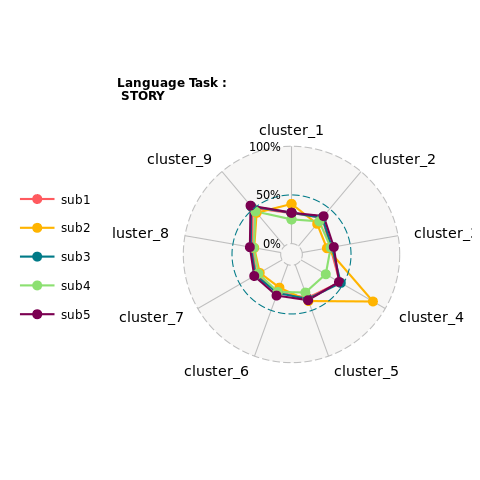

In [23]:
%%R -i path_root,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_root,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Language Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_root,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [24]:
.085480# plot association wieght and phenotypes
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_y =mat_load['model_raw']['y']
        model_x = mat_load['model_raw']['x']
        model_labels_x = mat_load['model_raw']['labels_x']
        model_labels_y = mat_load['model_raw']['labels_y']
        concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
        model_df = pd.DataFrame(concat)
        model_df.index = model_labels_x
        colnames = np.concatenate([list_subtype,model_labels_y])
        model_df.columns = colnames
        model_df.to_csv(os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name)))
        
        # plot association maps
        #for subtype in list_subtype:
        #    fig = plt.figure(figsize=(9,16))
        #    ax1 = fig.add_subplot(511)
        #    ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
        #    ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
        #    ax1.set_xlabel(pheno_name)

## Random forest regressionn assocaition 

In [25]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd # read csv and manip tables 
import scipy.io #read .mat files

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC,SVR,LinearSVC
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [26]:
model_df = model_df.reset_index().rename(columns={'index': 'Subject'})
model_df.head()

,Subject,sub1,sub2,sub3,sub4,sub5,FD_RL,FD_scrubbed_RL,FD_LR,FD_scrubbed_LR,...,Mother_ID,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,HCP100206,-0.044002,0.133014,0.038918,-0.088635,0.034384,0.088456,0.088456,0.099963,0.099963,...,56037.0,-1.143794,1.304835,1.285918,-0.034336,0.205086,0.053396,0.090798,-0.512524,-0.118881
1,HCP100307,0.577479,0.126689,-0.546649,0.399775,-0.528503,0.101970,0.101970,0.119331,0.119331,...,51488.0,-0.528411,0.493464,0.523816,-0.600763,0.386336,-0.953060,-0.958070,-0.143309,-0.722473
2,HCP100408,-0.206460,-0.082492,0.251270,-0.258280,0.240340,0.128052,0.128052,0.140232,0.140232,...,51730.0,-0.236296,0.020266,0.092588,0.114286,-0.084017,-0.522003,0.619392,0.219196,1.037169
3,HCP100610,0.272108,0.075579,-0.308281,0.324437,-0.321563,0.189474,0.189474,0.179002,0.179002,...,52813.0,2.022214,0.895451,-0.361691,1.234488,0.709151,-0.882736,-0.323026,-0.199254,0.459399
4,HCP101006,-0.068098,-0.102695,0.045742,0.002438,0.086594,0.156877,0.156877,0.131924,0.131924,...,51283.0,0.591952,-1.191472,0.037988,-0.682910,-0.516141,0.056823,-0.275139,-0.310782,0.308365


In [27]:
 # import all pheno data
all_pheno = pd.read_csv(os.path.join('/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/pheno/hcp_all_pheno_clean_nonan_norm.csv'))

In [28]:
# set subject names with Prefix HCP
all_pheno.rename(columns={'Unnamed: 0': 'Subject'},inplace=True)
all_pheno['Subject'] = 'HCP'+ all_pheno['Subject'].astype(str)
all_pheno.head()

,Subject,Handedness,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100004,0.654367,-0.262795,0.706508,-0.038133,0.912634,0.543120,-1.133786,0.964184,0.526831,...,-0.560257,-0.137093,0.904230,0.582300,0.871791,-0.430821,-0.682838,1.605890,-0.312732,1.863197
1,HCP100206,-0.008896,-0.057218,-0.392537,-0.584901,0.249934,1.010833,0.415954,1.810203,0.732102,...,0.600528,1.133355,2.036441,1.148677,2.255963,1.506107,2.573747,2.101592,1.602519,0.819628
2,HCP100307,0.654367,-0.715064,-0.529918,-0.676029,-0.744115,-0.050883,0.863311,0.022050,0.116291,...,-0.560257,-0.681571,-0.888437,-0.323905,-0.685403,-0.624514,-0.682838,-0.707386,-0.660960,-0.432656
3,HCP100408,-0.229983,0.141209,1.874244,1.511043,-0.081415,1.057825,-0.360372,0.885089,-1.936414,...,0.407063,-0.681571,-0.982788,-0.210629,-0.685403,-0.430821,-0.682838,-0.707386,-0.660960,-0.432656
4,HCP100610,0.433279,1.778676,1.118650,-0.220389,-0.081415,-0.166160,1.454289,1.420734,1.347913,...,-0.753721,-0.137093,0.432475,-0.323905,-0.685403,-0.624514,-0.682838,2.597294,-0.835073,-0.641370


In [29]:
# Merge al pheno with subttyp weights
all_pheno_pruned = pd.merge(model_df[['Subject','sub1','sub2','sub3','sub4','sub5','FD_scrubbed_mean']],all_pheno,on='Subject',how='left')
# Drop NaN
all_pheno_pruned.dropna(inplace=True)

In [30]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.utils import shuffle


# Set data X Y
data_X = all_pheno_pruned.drop(['Subject','sub1','sub2','sub3','sub4','sub5'],axis=1)
#mask = feature_importances >= np.percentile(mean_feimp,feimp_thresh)
#data_X = data_X[data_X.columns[mask]]
data_Y = all_pheno_pruned['sub2']
y = data_Y.values
scl = StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))

minmiax = MinMaxScaler(feature_range=(-1, 1))
y = minmiax.fit_transform(y)[:,0]

x =data_X.values
scl = StandardScaler()
x = scl.fit_transform(x)

x, y = shuffle(x, y, random_state=0)
# print shape
print('y shape:',y.shape)
print('x shape:',x.shape)

y shape: (781,)
x shape: (781, 67)


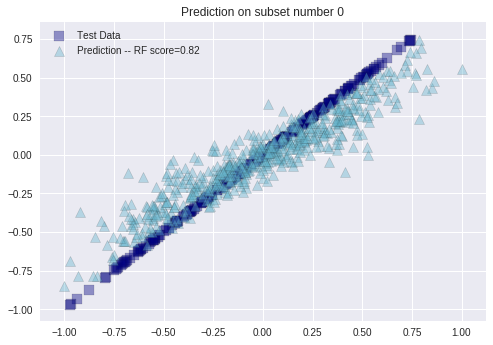

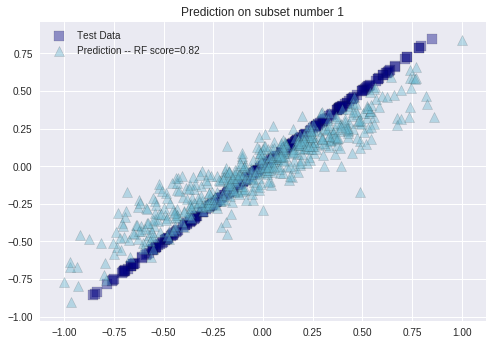

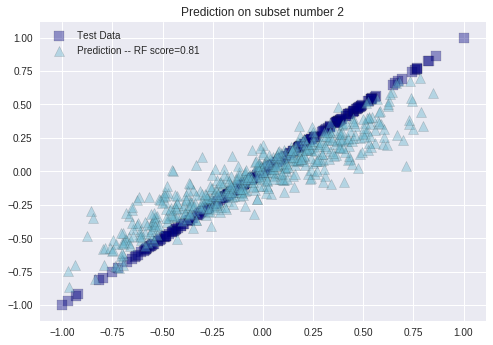

Mean R-squared : 0.816413423574


In [119]:
# apply machine learning : Random forest regression
rfr = RandomForestRegressor(n_estimators=10,oob_score=True,n_jobs=-1)
skf = KFold(n_splits=3)
feimp_l = np.zeros((skf.n_splits,x.shape[1]))
scores = np.zeros((skf.n_splits,1))
std =  np.zeros((skf.n_splits,x.shape[1]))

for c, (train_index, test_index) in enumerate(skf.split(x)):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    rfr.fit(x_train, y_train)
    pred = rfr.predict(x_train)
    
    rsq = rfr.score(x_train, y_train)
    scores[c,:] = rsq
    
    feimp = rfr.feature_importances_
    feimp_l[c,:] = feimp[:]
    
    std[c,:] = np.std([tree.feature_importances_ for tree in rfr.estimators_],axis=0)
    
    # Plot prediction
    #plt.figure()
    #plt.scatter(y_test,y_test,label='Test data')
    #plt.scatter(y_test,pred,label= 'Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #print('R-squared :',rsq)
    #plt.plot(y_test, y_test,'bo', label='Test data')
    #plt.plot(y_test, pred, 'co', label='Predicted data')
    #plt.title('R-squared :{}'.format(rsq))
    #plt.legend()
    #plt.show()
    s = 100
    a = 0.4
    plt.figure()
    plt.scatter(y_test, y_test, edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Test Data")

    plt.scatter(y_train, pred, edgecolor='k',
            c="c", s=s, marker="^", alpha=a,
            label="Prediction -- RF score=%.2f" % rsq)
    plt.title("Prediction on subset number {}".format(c))
    plt.legend()
    plt.show()
print('Mean R-squared :',scores.mean())

In [74]:
std.shape

(3, 67)

In [63]:
for idx, tree in enumerate(rfr.estimators_):
    pass

In [65]:
a=[tree.feature_importances_ for tree in rfr.estimators_]

In [70]:
np.std(np.array(a), 0)

array([ 0.01676795,  0.01815277,  0.01708841,  0.01671927,  0.02104886,
        0.01087359,  0.01560643,  0.01702204,  0.01851807,  0.01612881,
        0.01765162,  0.02510598,  0.04439078,  0.02006969,  0.02327367,
        0.02802005,  0.02199376,  0.01604834,  0.01080167,  0.01236734,
        0.01881571,  0.01050094,  0.01839556,  0.01244304,  0.0169768 ,
        0.01384547,  0.0187505 ,  0.01365257,  0.01218977,  0.01639451,
        0.01813208,  0.01311902,  0.01438068,  0.02122344,  0.01627536,
        0.01044073,  0.01348304,  0.01108545,  0.01215038,  0.01349345,
        0.01879077,  0.01450969,  0.00930211,  0.01888428,  0.0178206 ,
        0.02044034,  0.01243035,  0.0287444 ,  0.02575374,  0.01891833,
        0.01510677,  0.00683809,  0.00876083,  0.01025574,  0.00858762,
        0.01485308,  0.01153675,  0.01024562,  0.00736683,  0.01290976,
        0.01067713,  0.00673771,  0.00580366,  0.00959812,  0.00721715,
        0.02159877,  0.00770153])

In [71]:
 np.std([tree for tree in rfr.estimators_.feature_importances_],axis=0)

AttributeError: 'list' object has no attribute 'feature_importances_'

In [62]:
tree.feature_importances_.shape

(67,)

In [33]:
np.argsort(feimp_l)[::-1][0]

array([62, 51, 61, 64, 66, 58, 54, 52, 63, 53, 57, 42, 56,  5, 35, 18, 60,
       37, 28, 21, 55, 38, 59, 19, 23, 25, 46, 27, 39, 41, 31, 32, 36,  9,
       50, 29,  3, 34,  6, 30,  7, 16, 49, 40, 10, 17,  2, 44, 24,  0,  1,
        8, 22, 65, 33, 26, 13, 43,  4, 20, 45, 11, 14, 48, 15, 47, 12])

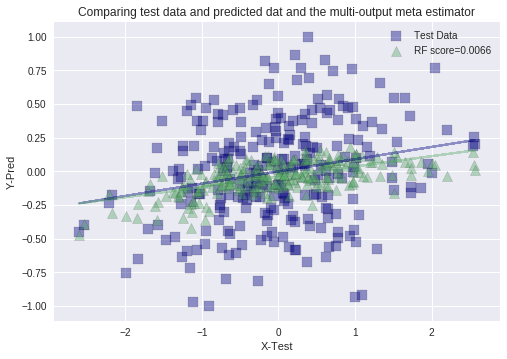

In [35]:
plt.figure()
s = 100
a = 0.4
x_ = x_test[:,np.argsort(mean_feimp)[::-1][0]]


fit_a = np.polyfit(x_, y_test, deg=1)
plt.plot(x_, fit_a[0] * x_ + fit_a[1], color='navy',alpha=a)
plt.scatter(x_, y_test, edgecolor='k',
            c="navy", s=s, marker="s", alpha=a, label="Test Data")


fit_b = np.polyfit(x_, pred, deg=1)
plt.plot(x_, fit_b[0] * x_ + fit_b[1], color='g',alpha=a)
plt.scatter(x_, pred, edgecolor='k',
            c="g", s=s, marker="^", alpha=a,
            label="RF score=%.4f" % rfr.score(x_test, y_test))


plt.xlabel("X-Test")
plt.ylabel("Y-Pred")
plt.title("Comparing test data and predicted dat and the multi-output meta estimator")
plt.legend()
plt.show()

In [77]:
feimp_l.shape

(3, 67)

In [78]:
mean_feimp.shape

(67,)

In [79]:
data_X.columns

Index(['FD_scrubbed_mean', 'Handedness', 'BMI', 'BPSystolic', 'BPDiastolic',
       'PSQI_Score', 'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj',
       'PMAT24_A_CR', 'PMAT24_A_RTCR', 'ReadEng_Unadj', 'PicVocab_Unadj',
       'ProcSpeed_Unadj', 'DDisc_AUC_200', 'DDisc_AUC_40K', 'VSPLOT_TC',
       'VSPLOT_CRTE', 'SCPT_TP', 'SCPT_TN', 'SCPT_TPRT', 'IWRD_TOT',
       'IWRD_RTC', 'ER40_CR', 'ER40_CRT', 'Sadness_Unadj', 'FearSomat_Unadj',
       'FearAffect_Unadj', 'AngAggr_Unadj', 'AngHostil_Unadj',
       'AngAffect_Unadj', 'LifeSatisf_Unadj', 'MeanPurp_Unadj',
       'PosAffect_Unadj', 'Friendship_Unadj', 'Loneliness_Unadj',
       'PercHostil_Unadj', 'PercReject_Unadj', 'EmotSupp_Unadj',
       'InstruSupp_Unadj', 'PercStress_Unadj', 'SelfEff_Unadj',
       'PainInterf_Tscore', 'Taste_Unadj', 'Dexterity_Unadj', 'Strength_Unadj',
       'NEOFAC_A', 'NEOFAC_O', 'NEOFAC_C', 'NEOFAC_N', 'NEOFAC_E',
       'ASR_Anxd_Pct', 'ASR_Witd_Pct', 'ASR_Soma_Pct', 'ASR_Thot_Pct',
       'ASR_Attn_

In [112]:
# Threshold future importance
feimp_thresh =0 # Percentile of future to be removed
mean_feimp = np.mean(feimp_l, axis=0)*100
mean_std = np.mean(std, axis=0)*100
feature_importances = pd.Series(mean_feimp,index= data_X.columns)
feature_importances_select = feature_importances[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
std_select = mean_std[feature_importances >= np.percentile(mean_feimp,feimp_thresh)]
indices = np.argsort(mean_feimp[feature_importances >= np.percentile(mean_feimp,feimp_thresh)])[::-1]

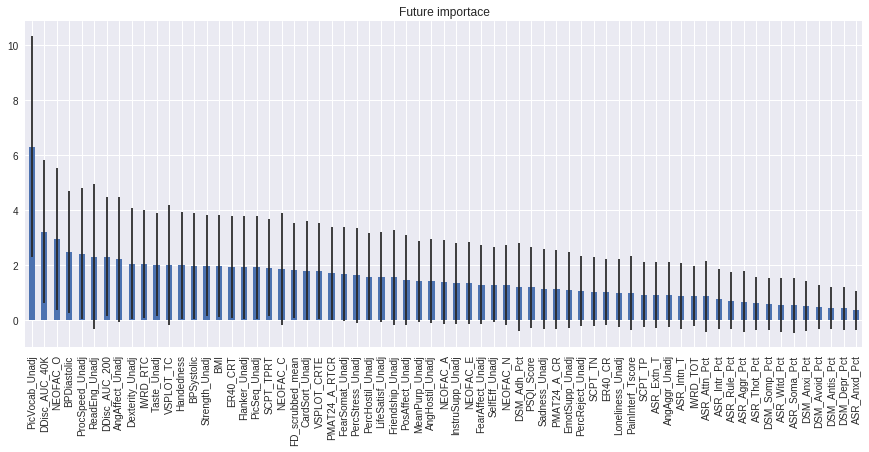

In [113]:
# Plot Future importance
feature_importances_select[indices].plot(kind='bar',yerr=std_select[indices],figsize=(15,6),title='Future importace')

In [114]:
feature_importances_select.shape

(67,)

In [86]:
std_select[indices].shape

(7,)

In [55]:
std_select[indices]

array([ 0.04077666,  0.02666512,  0.02569581,  0.02293904,  0.02577097,
        0.02358242,  0.02258951,  0.0232495 ,  0.02213536,  0.019513  ,
        0.01980177,  0.01993718,  0.01844075,  0.01900799,  0.01916055,
        0.01931735,  0.01880958,  0.01781674,  0.01802022,  0.01744809,
        0.01821948,  0.01905212,  0.01685157,  0.01801012,  0.01760456,
        0.01734492,  0.0165698 ,  0.01745782,  0.01630625,  0.01578527,
        0.0163915 ,  0.01498608,  0.01459827,  0.01459108,  0.01478467,
        0.01453292,  0.01404034,  0.01471617,  0.01601943,  0.01432817,
        0.01476781,  0.01425898,  0.01447271,  0.01341818,  0.01220963,
        0.01168228,  0.01196257,  0.01184435,  0.01236805,  0.01342578,
        0.01125596,  0.01213975,  0.01159846,  0.01207931,  0.01260378,
        0.0112299 ,  0.01005449,  0.01093733,  0.00945767,  0.00984837,
        0.00973505,  0.00942064,  0.00838438,  0.00870163,  0.00805781,
        0.00754506,  0.00692877])

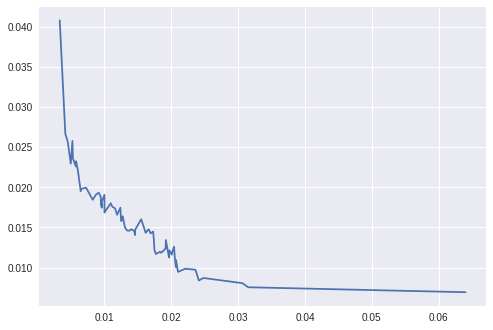

In [58]:
plt.plot(feature_importances_select,std_select[indices])

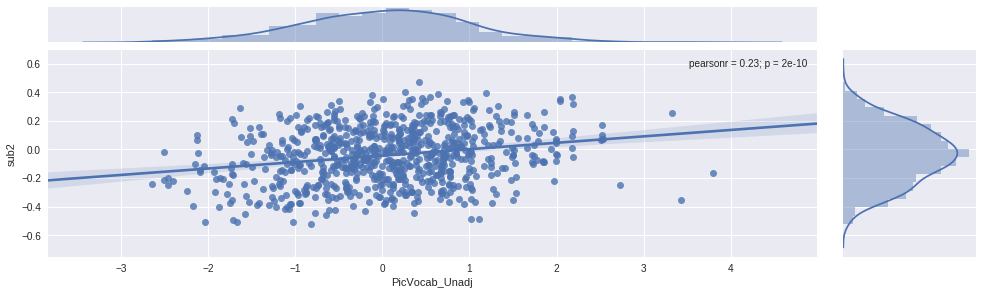

In [73]:
grid = sns.jointplot( y="sub2", x="PicVocab_Unadj", data=all_pheno_pruned,kind='reg');
grid.fig.set_figwidth(15)
grid.fig.set_figheight(4)

In [152]:
rng = np.random.RandomState(1)
X = np.sort(200 * rng.rand(600, 1) - 100, axis=0)
y = np.array([np.pi * np.sin(X).ravel(), np.pi * np.cos(X).ravel()]).T
y += (0.5 - rng.rand(*y.shape))


In [186]:
np.argsort(mean_feimp)[::-1]

array([12, 47, 15, 45, 13, 11,  4, 43, 14, 20, 22, 30,  1,  2,  3,  6, 16,
        0, 26, 36,  8, 17, 44, 24, 31, 40, 48, 10, 32, 34, 49, 50,  7, 27,
       41, 39, 33, 29,  5, 46, 65,  9, 42, 25, 38, 28, 18, 23, 19, 21, 35,
       55, 37, 60, 58, 59, 57, 62, 56, 52, 53, 63, 64, 54, 66, 61, 51])

In [24]:
log = LinearRegression()
log.fit(x,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
predRfr = rfr.predict(x_test)
predLog = log.predict(x_test)

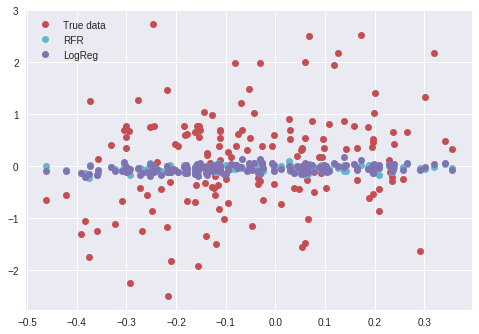

In [149]:
plt.plot(y_test, x_test[:,np.argsort(mean_feimp)[::-1][0]],'ro', label='True data')
plt.plot(y_test, predRfr, 'co', label='RFR')
plt.plot(y_test, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()plt.plot(y_test, x_test[:,np.argsort(mean_feimp)[::-1][0]],'ro', label='True data')
plt.plot(y_test, predRfr, 'co', label='RFR')
plt.plot(y_test, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()

In [76]:
scl = preprocessing.StandardScaler()
y = scl.fit_transform(y.reshape(-1, 1))[:,0]
#x = scl.fit_transform(x)

In [126]:
# init CV
scores = []
skf = KFold(n_splits=3)
for train_index, test_index in skf.split(x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # train model
    clf = SVR(kernel='linear', C=1e3)
    #clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
    
    # grid search cv
    #clf = GridSearchCV(clf, cv=10,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)},n_jobs=6)

    clf.fit(x_train, y_train)
    #sv_ratio = clf.best_estimator_.support_.shape[0] / (1.*len(y_train))
    #print("Support vector ratio: %.3f" % sv_ratio)
    
    # test
    scores.append(clf.score(x_test,y_test))
    #print(scl.inverse_transform(clf.predict(x_test)))
    print(scores[-1])
    
print('Average R2: ', np.mean(scores))


0.0643228755385
0.038372600127
0.0508334175103
Average R2:  0.0511762977253


In [156]:
# train model
#clf = SVR(kernel='rbf', C=1.0, epsilon=0.2, gamma=.0001)
clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
log = LinearRegression()
# grid search cv
#clf = GridSearchCV(clf, cv=10,param_grid={"C": [1e0, 1e1, 1e2, 1e3],"gamma": np.logspace(-2, 2, 5)},n_jobs=6)
log.fit(x,y)
clf.fit(x,y)

ValueError: Found input variables with inconsistent numbers of samples: [782, 506]

In [131]:
predSvr = clf.predict(x_test)
predLog = log.predict(x_test)

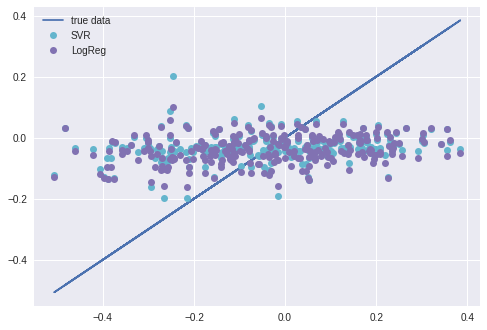

In [132]:
plt.plot(y_test, y_test, label='true data')
plt.plot(y_test, predSvr, 'co', label='SVR')
plt.plot(y_test, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()

In [71]:
plt.plot(testY, predLog, 'mo', label='LogReg')
plt.legend()
plt.show()

NameError: name 'testY' is not defined

In [50]:
clf = SVR(kernel='rbf', C=1e1, gamma=0.1)
r = clf.fit(b, y_train)

In [53]:
print(r)

SVR(C=10.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [47]:
b = np.concatenate((np.ones(x_train.shape + (1,)), x_train[..., None]),1)

In [54]:
b

array([[ 1.        , -0.30849142],
       [ 1.        , -0.02320696],
       [ 1.        ,  0.08609446],
       ..., 
       [ 1.        ,  0.0869828 ],
       [ 1.        , -0.06180076],
       [ 1.        ,  0.03654179]])

In [48]:
b.shape

(521, 2)

In [35]:
x_train.shape

(521,)

In [36]:
y_train.shape

(521,)

In [43]:
y_train

array([  7.19714152e-01,  -6.16568569e-01,   7.51768143e-01,
        -2.56341148e-01,  -2.08548321e-01,   1.65869777e+00,
        -1.07640005e+00,  -7.56461032e-01,   1.39542587e+00,
        -1.22367986e+00,   2.70661413e+00,   1.62839525e+00,
        -1.33460468e+00,  -6.48535360e-01,  -3.56882679e-01,
        -3.44448382e-01,  -7.45097222e-01,   1.42174704e+00,
        -2.22163437e-01,  -9.20499026e-01,  -1.24371487e-01,
         1.16767668e+00,   1.06133380e+00,  -1.02564102e+00,
        -1.18123405e+00,  -4.89680258e-01,   2.24736959e-01,
        -8.24886981e-01,   1.15202306e+00,  -5.01649091e-01,
        -1.55980532e+00,  -9.39876426e-03,  -1.13018284e+00,
        -7.59630933e-01,   1.67678220e+00,  -9.78152128e-01,
         1.64552427e+00,   4.88957728e-02,  -5.34707072e-01,
         1.05340894e+00,  -1.29770426e+00,  -1.43982040e+00,
        -1.38773599e+00,   7.50200078e-01,  -3.53643982e-01,
         1.19984200e+00,   2.91774550e+00,  -2.99774797e-01,
         7.62898879e-01,

In [42]:
x_train

array([-0.30849142, -0.02320696,  0.08609446,  0.18430688, -0.21208545,
       -0.58278535,  0.00305323, -0.77162255, -0.45663901,  0.05136636,
        0.22729541, -0.16015158, -0.68875003, -0.43226511,  0.05376947,
        0.22713237, -0.88893138, -0.37382915, -0.02761577, -0.4243101 ,
        0.26484978, -0.54914459, -0.12306755,  0.45521993,  0.15100539,
       -0.20144924, -0.17204038, -0.10768164, -0.15872905, -0.33746947,
       -0.47054225,  0.08342435,  0.23408141,  0.13521806,  0.17529201,
       -0.11546233,  0.12689403,  0.10487231,  0.24965284, -0.86906494,
       -0.59365779,  0.03719171,  0.39182195, -0.0533519 ,  0.3295965 ,
        0.12125083, -0.15920628,  0.08991829, -0.13515812,  0.02440385,
        0.21928849,  0.01790158,  0.06929018,  0.15320444, -0.08628468,
        0.20753865, -0.02964557,  0.04064956, -0.2006894 ,  0.33961272,
        0.08358905, -0.38963218, -0.1998677 , -0.02621379, -0.18704808,
       -0.22423859,  0.51361047, -0.46549336,  0.00626338, -0.83

In [37]:
type(y_train)

numpy.ndarray

In [38]:
type(x_train)

numpy.ndarray

In [40]:
np.sum(np.isnan(y_train))

0